# Pseudo-spectral Solver

> A pseudo-spectral solver for the 1D wave equation.

In [ ]:
# | default_exp solver.wave1d_pseudospectral


The wave equation in 1D is given by:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

where $c$ is the wave speed. 

In the pseudo-spectral method, we transform the derivatives in space to the frequency domain, solve the equation in the frequency domain, and then transform back to the spatial domain. We solve the problem and iterate using an ode solver.

The 2nd derivative in space is given by:

$$
\frac{\partial^2 u}{\partial x^2} = \mathcal{F}^{-1} \left[ (ik)^2 \mathcal{F} \left( u \right) \right]
$$

where $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the forward and inverse Fourier transforms, respectively, and $k$ is the wavenumber.

In [ ]:
# | export

import numpy as np
from scipy.integrate import solve_ivp
from typing import Tuple

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# | export


def fourier_derivative_2(
    u: np.ndarray,  # function in physical space
    k: np.ndarray,  # wave number array
):
    """
    Compute the 2nd derivative of a function in Fourier space, and return the result in physical space.
    """
    u_hat = np.fft.fft(u)
    dudx2 = (1j * k) ** 2 * u_hat  # 2nd derivative
    return np.real(np.fft.ifft(dudx2))

Define the right-hand side of the equation as

In [ ]:
# | export


class Wave1dSolverPseudoSpectral:
    """
    This class solves the 1D wave equation using the pseudo-spectral method.
    Inspired by the content in https://www.coursera.org/learn/computers-waves-simulations/home/week/5
    It assumes dirchlet boundary conditions on both ends of the string.
    """

    def __init__(
        self,
        sampling_rate: float,  # sampling rate in Hz
        final_time: float,  # final time in seconds
        length: float,  # length of the string in meters
        n_gridpoints: int,  # number of points in the string
        wave_speed: float = 1,  # wave speed in m/s
    ):
        self.sampling_rate = sampling_rate
        self.final_time = final_time
        self.length = length
        self.wave_speed = wave_speed
        self.n_gridpoints = n_gridpoints

        self.dt = 1 / self.sampling_rate
        self.timesteps = np.arange(0, self.final_time, self.dt)
        self.grid = np.linspace(0, self.length, self.n_gridpoints)
        self.dx = self.grid[1] - self.grid[0]
        self.pde_order_time_derivatives = 2

        print(f"dx: {self.dx} in meters")
        print(f"dt: {self.dt} in seconds")
        print(f"number of points (n_gridpoints): {self.grid.shape}")
        print(f"time in samples (nt): {self.timesteps.shape}")

        # Wave numbers for Fourier differentiation in space
        self.n_modes = 2 * np.pi * np.fft.fftfreq(self.n_gridpoints, d=self.dx)

    def solve(
        self,
        u0: np.ndarray,  # initial position
        v0: np.ndarray,  # initial velocity
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:  # Returns time, position, velocity
        """
        Solve the wave equation using the pseudo-spectral method.
        """

        def wave_equation(
            t,  # time
            state,  # state vector
            c: float,  # wave speed
            k: np.ndarray,  # wave number array
            n_gridpoints: int,  # number of grid points
        ) -> np.ndarray:  # state at timestep t and position x (u(x, t))
            """
            Right hand side of the wave equation
            """

            u = state[:n_gridpoints]  # position
            v = state[n_gridpoints:]  # velocity

            # Set dirchlet boundary conditions
            # before computing the 2nd derivative
            u[0] = 0
            u[-1] = 0

            # 2nd derivative of position
            dudx2 = fourier_derivative_2(u, k)

            dv_dt = c**2 * dudx2

            v[0] = 0
            v[-1] = 0

            # return the state derivatives
            return np.concatenate([v, dv_dt])

        # solve the wave equation
        sol = solve_ivp(
            fun=wave_equation,
            t_span=[0, self.final_time],
            y0=np.concatenate([u0, v0], axis=0),
            method="RK45",
            t_eval=self.timesteps,
            args=(self.wave_speed, self.n_modes, self.n_gridpoints),
        )

        return sol.t, sol.y[: self.n_gridpoints].T, sol.y[self.n_gridpoints :].T

Test the solver

In [ ]:
from physmodjax.solver.generator import Gaussian


In [ ]:
n_gridpoints = 1000
solver = Wave1dSolverPseudoSpectral(
    sampling_rate=44100,
    final_time=1,
    length=1,
    n_gridpoints=n_gridpoints,
    wave_speed=1,
)

u0 = Gaussian(num_points=n_gridpoints)()
v0 = np.zeros_like(u0)

t, u, v = solver.solve(u0, v0)


dx: 0.010101010101010102 in meters
dt: 2.0833333333333333e-05 in seconds
number of points (n_gridpoints): (100,)
time in samples (nt): (48000,)
(48000,) (48000, 100) (48000, 100)


[<matplotlib.lines.Line2D>]

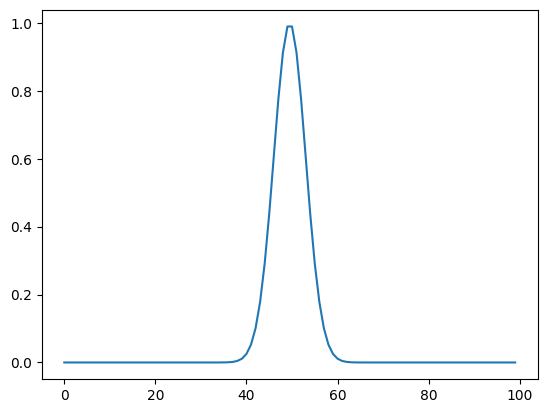

In [ ]:
# | eval : false

# show the solution viewed from above
plt.figure(figsize=(5, 10))
plt.pcolormesh(solver.grid, t[::100], u[::100])
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()
